In [1]:
import starepandas
import geopandas
import pandas
import datetime
import matplotlib.pyplot as plt

In [2]:
cities = ['Buenos Aires', 'Brasilia', 'Santiago', 
          'Bogota', 'Caracas', 'Sao Paulo', 'Bridgetown']

latitudes = [-34.58, -15.78, -33.45, 4.60, 10.48, -23.55, 13.1]
longitudes = [-58.66, -47.91, -70.66, -74.08, -66.86, -46.63, -59.62]
data =  {'City': cities, 
         'Latitude': latitudes, 'Longitude': longitudes}

cities = starepandas.STAREDataFrame(data)
stare = starepandas.stare_from_xy(cities.Longitude, cities.Latitude, level=27)
geom = geopandas.points_from_xy(cities.Longitude, cities.Latitude, crs='EPSG:4326')
cities.set_stare(stare, inplace=True)
cities.set_geometry(geom, inplace=True)
cities.set_trixels(inplace=True)

In [3]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
countries = countries.sort_values(by='name')
countries['geom_simple'] = countries.simplify(0.002)
countries.set_geometry('geom_simple', inplace=True)
samerica = countries[countries.continent=='South America']

stare = starepandas.stare_from_gdf(samerica, level=9, force_ccw=True)
samerica = starepandas.STAREDataFrame(samerica, stare=stare)
trixels = samerica.trixels()
samerica.set_trixels(trixels, inplace=True)

# Geopandas spatial join

In [4]:
geopandas.sjoin(samerica, cities, how='left').head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,geom_simple,stare_left,trixels_left,index_right,City,Latitude,Longitude,stare_right,trixels_right
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...","MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...","[1831909517177126920, 1831927109363171336, 183...",(POLYGON ((-67.84209847159167 -53.768136050714...,0.0,Buenos Aires,-34.58,-58.66,2.663379e+18,POLYGON ((-58.65999966200309 -34.5800001759415...
30,11138234,South America,Bolivia,BOL,78350.0,"POLYGON ((-69.52968 -10.95173, -68.78616 -11.0...","POLYGON ((-69.52968 -10.95173, -68.78616 -11.0...","[2684145377912815620, 2692026677260713989, 270...",(POLYGON ((-62.76427600784291 -18.886669386799...,NaN,NaN,NaN,NaN,NaN,NaN
29,207353391,South America,Brazil,BRA,3081000.0,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...","POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...","[2749447572509687812, 2796735368597078020, 286...",(POLYGON ((-53.69933849725345 -4.6308011280983...,1.0,Brasilia,-15.78,-47.91,2.867415e+18,POLYGON ((-47.90999951241486 -15.7799995312697...
29,207353391,South America,Brazil,BRA,3081000.0,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...","POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...","[2749447572509687812, 2796735368597078020, 286...",(POLYGON ((-53.69933849725345 -4.6308011280983...,5.0,Sao Paulo,-23.55,-46.63,2.803226e+18,POLYGON ((-46.62999963470963 -23.5500000219939...
10,17789267,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...","MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...","[1829024398665842695, 1831839148432949255, 183...",(POLYGON ((-70.49911208115833 -54.876220492643...,2.0,Santiago,-33.45,-70.66,2.723775e+18,POLYGON ((-70.66000060651589 -33.4499996318796...


In [5]:
starepandas.stare_join(samerica, cities, how='left').head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,geom_simple,stare_left,trixels_left,_key_left,City,Latitude,Longitude,stare_right,trixels_right
index_left,,,,,,,,,,,,,,,
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...","MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...","[1831909517177126920, 1831927109363171336, 183...",(POLYGON ((-67.84209847159167 -53.768136050714...,9.0,Buenos Aires,-34.58,-58.66,2.663379e+18,POLYGON ((-58.65999966200309 -34.5800001759415...
30,11138234,South America,Bolivia,BOL,78350.0,"POLYGON ((-69.52968 -10.95173, -68.78616 -11.0...","POLYGON ((-69.52968 -10.95173, -68.78616 -11.0...","[2684145377912815620, 2692026677260713989, 270...",(POLYGON ((-62.76427600784291 -18.886669386799...,29.0,Brasilia,-15.78,-47.91,2.867415e+18,POLYGON ((-47.90999951241486 -15.7799995312697...
29,207353391,South America,Brazil,BRA,3081000.0,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...","POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...","[2749447572509687812, 2796735368597078020, 286...",(POLYGON ((-53.69933849725345 -4.6308011280983...,10.0,Santiago,-33.45,-70.66,2.723775e+18,POLYGON ((-70.66000060651589 -33.4499996318796...
10,17789267,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...","MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...","[1829024398665842695, 1831839148432949255, 183...",(POLYGON ((-70.49911208115833 -54.876220492643...,32.0,Bogota,4.60,-74.08,2.667982e+18,POLYGON ((-74.08000055364545 4.600000473178588...
32,47698524,South America,Colombia,COL,688000.0,"POLYGON ((-66.87633 1.25336, -67.06505 1.13011...","POLYGON ((-66.87633 1.25336, -67.06505 1.13011...","[2666130979403333637, 2667256879310176261, 266...",(POLYGON ((-75.36119345626975 8.42105871140566...,40.0,Caracas,10.48,-66.86,2.494082e+18,POLYGON ((-66.86000048291646 10.48000050718471...


## Hand-rolling a join

In [6]:
left_df = cities
right_df = samerica

left_key = []
right_key = []
for i, row in right_df.iterrows():  
    k = left_df.index[left_df.intersects(row.geometry)]
    left_key.extend(list(k))
    right_key.extend([i]*len(k))

indices = pandas.DataFrame({'_key_left': left_key, 
                            '_key_right':right_key})
indices

,_key_left,_key_right
0,0,9
1,1,29
2,5,29
3,2,10
4,3,32
5,4,40


In [7]:
left_key = []
right_key = []

for i, row in right_df.iterrows():  
    k = left_df.index[left_df.stare_intersects(row.stare)]
    left_key.extend(list(k))
    right_key.extend([i]*len(k))

indices = pandas.DataFrame({'_key_left': left_key, 
                            '_key_right': right_key})

indices

,_key_left,_key_right
0,0,9
1,1,29
2,5,29
3,2,10
4,3,32
5,4,40


In [8]:
# Inner join
joined = left_df
joined = joined.merge(indices, left_index=True, right_index=True)
joined = joined.merge(right_df, left_on='_key_right', right_index=True)
joined = joined.set_index('_key_left')
joined = joined.drop(["_key_right"], axis=1)

In [9]:
# Left Join
index_left = 'index_left'
left_df.index = left_df.index.rename(index_left)
left_df = left_df.reset_index()

joined = left_df
joined = joined.merge(indices, left_index=True, right_index=True, how="left")
joined = joined.merge(right_df.drop(right_df.geometry.name, axis=1),
                      how="left",
                      left_on="_key_right",
                      right_index=True,
                      suffixes=("_left", "_right"))
joined = joined.set_index(index_left)
joined = joined.drop(["_key_right"], axis=1)

# Granule Intersect

In [19]:
fname = 'data/MYD05_L2.A2020060.1635.061.2020061153519.hdf'
modis = starepandas.read_modis_base(fname)
geom = geopandas.points_from_xy(modis.lon, modis.lat, crs='EPSG:4326')
modis.set_geometry(geom, inplace=True)
trixels = modis.trixels()
modis.set_trixels(trixels=trixels, inplace=True)
brazil = samerica[samerica.name=='Brazil']

## STARE

In [11]:
start = datetime.datetime.now()
a = modis.stare_intersects(brazil.stare.iloc[0])
print(datetime.datetime.now() - start)

0:01:34.447631


## Conventional

In [12]:
start = datetime.datetime.now()
b = modis.intersects(brazil.iloc[0].geometry)
print(datetime.datetime.now() - start)

0:00:27.318856


<AxesSubplot:>

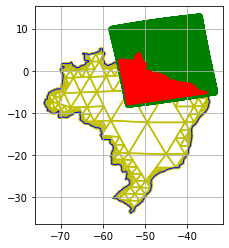

In [22]:
fig, ax = plt.subplots()
ax.grid(True)

brazil.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=0)
brazil.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)
modis[a].plot(ax=ax, color='red', trixels=True)
modis.plot(ax=ax, color='green')

In [23]:
modis

,lat,lon,stare,geometry,trixels
0,-4.923621,-33.579193,2833105768974759241,POINT (-33.57919 -4.92362),POLYGON ((-33.74330018504611 -4.97737466715193...
1,-4.956750,-33.786446,2833110603003551593,POINT (-33.78645 -4.95675),POLYGON ((-33.88021033388827 -4.75336867109179...
2,-4.988602,-33.986107,2833112722354712041,POINT (-33.98611 -4.98860),POLYGON ((-34.09080728125019 -5.17770047899378...
3,-5.019270,-34.178722,2833084363820531337,POINT (-34.17872 -5.01927),POLYGON ((-34.09080728125019 -5.17770047899378...
4,-5.048833,-34.364750,2833230005031123593,POINT (-34.36475 -5.04883),POLYGON ((-34.33318955674702 -5.16576169655812...
...,...,...,...,...,...
109615,10.103586,-57.200943,2499696282523506889,POINT (-57.20094 10.10359),POLYGON ((-57.42028735496672 10.08866040490541...
109616,10.071841,-57.382591,2499763921241658537,POINT (-57.38259 10.07184),POLYGON ((-57.42028735496672 10.08866040490541...
109617,10.038896,-57.570473,2499750202427574985,POINT (-57.57047 10.03890),POLYGON ((-57.42028735496672 10.08866040490541...
109618,10.004664,-57.765011,2499745802665205321,POINT (-57.76501 10.00466),POLYGON ((-57.89608244573355 10.07126624681429...
